<img src='./img/img2.jpg' vspace='15px' hspace='15px'/>
<h1><center>Análise de Sentimentos - B4 Bank</center></h1>

Nesse projeto nós faremos uma avaliação de 2 base de dados do cliente 'B4 Bank' que é um aplicativo do setor financeiro. Nosso objetivo é avaliar esses dados, ter insights e responder à algumas perguntas que já vamos conhecer.  
O B4 Bank é cliente há alguns meses e eles gostariam de saber como tem sido a performance do app. Como trabalhamos com ASO (App Store Optimization) para este cliente, o que mais nos interessa são as métricas de Canal Orgânico. É a partir deste KPI que nos baseamos para verificar o impacto do nosso trabalho. O cliente também deseja ter insights sobre o que os usuários estão comentando na loja e qual a sua situação diante dos seus concorrentes.

### Nesse projeto nós vamos:  
- Realizar uma análise exploratória dos dados com a base de dados do B4 Bank;
- Extrair alguns insights da análise;
- Realizar análise de sentimentos;
- Utilizar modelos de Machine Learning para classificar sentimentos.

<a name='TOPO'></a>
<h1>Índice</h1>
<ol>
    <li><a href='#CONHECENDO'>Conhecendo nossos Dados</a>
    <li><a href='#LIMPEZA'>Limpeza de Dados</a></li>
    <li><a href='#ANALISANDO'>Analisando e Explorando os Dados</a></li>
        <ul>
            <li><a href='#AVALIACOES'>Avaliações mensais</a></li>
            <li><a href='#VERSOES'>Versões mais bem avaliadas</a></li>
            <li><a href='#EVOLUCAO'>Evolução da última versão</a></li>
            <li><a href='#AVALIACOESR'>Avaliações em relação a hora do dia</a></li>
            <li><a href='#CANAIS'>Canais de aquisição</a></li>
            <li><a href='#CANAL'>Canal Orgânico x canais não orgânicos</a></li>
        </ul>
    <br/>
    <li><a href='#SENTIMENTOS'>Análise de Sentimentos</a></li>
            <ul>
            <li><a href='#PRE'>Limpeza e pré-processamento dos Dados</a></li>
            <li><a href='#NUVEM'>Nuvem de palavras</a></li>
            <li><a href='#FRASE'>Quantidade de palavras por frase</a></li>
            <li><a href='#REALIZANDO'>Realizando Resample</a></li>
            <li><a href='#ML'>Machine Learning</a></li>
            <li><a href='#VALIDACAO'>Validação dos modelos de ML</a></li>
            <li><a href='#PREVENDO'>Prevendo sentimentos</a></li>
        </ul>
    <br/>
</ol>

In [1]:
# Importação de bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import re
import collections
from wordcloud import WordCloud
from sklearn.utils import resample

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando bibliotecas para apresentação de gráficos mais atraentes e interativos.
import plotly.offline as py
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.offline import iplot

Vamos começar passando nossos dados para um dataframe, para isso primeiro vamos passar nosso arquivo .xlsx para uma variável para posteriormente pegar apenas as guias de planilhas necessárias.

In [3]:
# Passando nosso arquivo xlsx para uma variável
xlsx = pd.ExcelFile('data.xlsx')

In [4]:
# Tranformando a guia 'Retained_Bank' da planilha em dataframe e já passando a coluna 'Date' para o formato de data
retained = pd.read_excel(xlsx, 'Retained_Bank', parse_dates=['Date'])

In [5]:
# Transformando a guia 'Reviews_Bank' em dataframe
reviews = pd.read_excel(xlsx, 'Reviews_Bank')

<a name="CONHECENDO"></a>
<h1>1. Conhecendo nossos Dados</h1>

<a href='#TOPO'>Voltar ao índice</a>

No arquivo retained podemos notar que nossa coluna 'Date' ainda está como objeto. Vamos posteriormente passá-la para o formato correto.

In [6]:
retained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  317 non-null    object 
 1   Package Name                          317 non-null    object 
 2   Acquisition Channel                   317 non-null    object 
 3   Store Listing Visitors                317 non-null    int64  
 4   Installers                            317 non-null    int64  
 5   Visitor-to-Installer conversion rate  317 non-null    float64
 6   Installers retained for 1 day         317 non-null    int64  
 7   Installer-to-1 day retention rate     317 non-null    float64
 8   Installers retained for 7 days        317 non-null    int64  
 9   Installer-to-7 days retention rate    317 non-null    float64
 10  Installers retained for 15 days       317 non-null    int64  
 11  Installer-to-15 day

No arquivo reviews podemos notar que faltam alguns dados em algumas colunas, já daremos uma olhada mais de perto neles.  
Podemos notar também que como no retained o campo 'Review Last Update Date and Time' não está no formato de data. Já resolveremos isso.

In [7]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5679 entries, 0 to 5678
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Package Name                      5679 non-null   object
 1   App Version Name                  5423 non-null   object
 2   Reviewer Language                 5679 non-null   object
 3   Device                            5673 non-null   object
 4   Review Last Update Date and Time  5679 non-null   object
 5   Star Rating                       5679 non-null   int64 
 6   Review Title                      1 non-null      object
 7   Review Text                       2756 non-null   object
 8   Sentiment                         1428 non-null   object
dtypes: int64(1), object(8)
memory usage: 399.4+ KB


In [8]:
# Shape do nossos 2 dataframes
retained.shape ,reviews.shape

((317, 14), (5679, 9))

Aqui constatamos a quantidade de dados nulos faltantes.  
Vamos tratar todos eles na limpeza de dados, mas é importante ressaltar que vamos realizar a predição dos dados faltantes dos sentimentos.

In [9]:
# Quantidade de dados nulos por coluna
reviews.isnull().sum()

Package Name                           0
App Version Name                     256
Reviewer Language                      0
Device                                 6
Review Last Update Date and Time       0
Star Rating                            0
Review Title                        5678
Review Text                         2923
Sentiment                           4251
dtype: int64

In [10]:
# Amostra do nosso dataframe
reviews.head()  # Mostrando apenas os 5 primeiros

Package Name App Version Name Reviewer Language       Device  \
0      B4 Bank           6.10.6                pt     greatlte   
1      B4 Bank           6.10.6                pt         mido   
2      B4 Bank           6.10.6                pt     on5xelte   
3      B4 Bank           6.10.6                pt     dreamlte   
4      B4 Bank           6.10.6                pt  starqltechn   

  Review Last Update Date and Time  Star Rating Review Title  \
0             2019-10-01T00:09:07Z            5          NaN   
1             2019-10-01T00:18:49Z            5          NaN   
2             2019-10-01T00:34:35Z            5          NaN   
3             2019-10-01T00:44:18Z            2          NaN   
4             2019-10-01T01:09:56Z            4          NaN   

                                         Review Text Sentiment  
0                                                NaN  Positive  
1                                                NaN  Positive  
2                                                Boa  Positive  
3  Não consigo gerar a fatura em PDF, no mesmo fo...  Negative  
4                                                NaN  Positive

In [11]:
# Amostra do nosso dataframe
retained.head()  # Mostrando apenas os 5 primeiros

Date Package Name     Acquisition Channel  \
0  2019-08-01 00:00:00      B4 Bank                 Organic   
1  2019-08-01 00:00:00      B4 Bank   Third-party referrers   
2  2019-08-01 00:00:00      B4 Bank                   Other   
3  2019-08-02 00:00:00      B4 Bank                 Organic   
4  2019-08-02 00:00:00      B4 Bank  Tracked channels (UTM)   

   Store Listing Visitors  Installers  Visitor-to-Installer conversion rate  \
0                    1628         414                                 0.254   
1                     514          46                                 0.089   
2                     113          23                                 0.204   
3                    1610         407                                 0.253   
4                      55          10                                 0.182   

   Installers retained for 1 day  Installer-to-1 day retention rate  \
0                            359                              0.867   
1                             38                              0.826   
2                             17                              0.739   
3                            354                              0.870   
4                             10                           1000.000   

   Installers retained for 7 days  Installer-to-7 days retention rate  \
0                             344                               0.831   
1                              35                               0.761   
2                              17                               0.739   
3                             338                               0.830   
4                              10                            1000.000   

   Installers retained for 15 days  Installer-to-15 days retention rate  \
0                              335                                0.809   
1                               32                                0.696   
2                               14                                0.609   
3                              330                                0.811   
4                                9                                0.900   

   Installers retained for 30 days  Installer-to-30 days retention rate  
0                              330                                0.797  
1                               30                                0.652  
2                               13                                0.565  
3                              322                                0.791  
4                                8                                0.800

<a name="LIMPEZA"></a>
<h1>2. Limpeza dos Dados</h1>

<a href='#TOPO'>Voltar ao índice</a>

#### Datas

Realizar a conversão do tipo de coluna de objeto para data não é possível. Isso porque nosso arquivo contém 4 registros que são considerados anomalias. Esses 4 registros tem a mesma data 31/09/2019, porém, essa data não existe no calendário. Poderíamos supor que foi um erro de digitação, mas as datas seguintes e anteriores correspondem ao calendário oficial, portanto, vamos apenas excluir esses 4 registros que aparentemente não farão tanta diferença para a análise.

In [12]:
# Vamos comentar a tentativa de fazer a conversão
#retained['Date'] = pd.to_datetime(retained['Date'], format='%Y-%m-%d')

In [13]:
# Mostrando os 4 registros com anomalias de data
retained.loc[retained['Date'].str.contains('31/09/2019')]

Date Package Name     Acquisition Channel  Store Listing Visitors  \
196  31/09/2019      B4 Bank                 Organic                    1874   
197  31/09/2019      B4 Bank  Tracked channels (UTM)                    1204   
198  31/09/2019      B4 Bank   Third-party referrers                    2000   
199  31/09/2019      B4 Bank                   Other                      90   

     Installers  Visitor-to-Installer conversion rate  \
196         275                                 0.147   
197          10                                 0.008   
198         156                                 0.078   
199          12                                 0.133   

     Installers retained for 1 day  Installer-to-1 day retention rate  \
196                            249                              0.905   
197                             10                           1000.000   
198                            121                              0.776   
199                             11                              0.917   

     Installers retained for 7 days  Installer-to-7 days retention rate  \
196                             242                               0.880   
197                               9                               0.900   
198                             100                               0.641   
199                              10                               0.833   

     Installers retained for 15 days  Installer-to-15 days retention rate  \
196                              234                                0.851   
197                                9                                0.900   
198                               91                                0.583   
199                               10                                0.833   

     Installers retained for 30 days  Installer-to-30 days retention rate  
196                              229                                0.833  
197                                9                                0.900  
198                               78                                0.500  
199                               10                                0.833

In [14]:
# Passando o indice dos 4 registros para uma variavel
delete_rows = retained.loc[retained['Date'].str.contains('31/09/2019')].index

In [15]:
# Deletando os 4 registros
retained.drop(delete_rows, inplace=True)

Agora sim vamos passar as 2 colunas de datas para seu formato correto

In [16]:
# Convertendo a coluna 'Date' para o formato de data
retained['Date'] = pd.to_datetime(retained['Date'], format='%Y-%m-%d')

In [17]:
# Convertendo a coluna 'Review Last Update Date and Time' para o formato de data
reviews['Review Last Update Date and Time'] = pd.to_datetime(reviews['Review Last Update Date and Time'], format='%Y-%m-%d')

#### Analisando dados nulos

Agora vamos tratar a coluna 'App Version Name' onde faltam 256 dados, que corresponde a 4,5% dos dados.  
Como são poucos dados vou substituir esses dados nulos por 'Others', excluir significaria uma perda significativa de informações.

In [18]:
# Todas as versões únicas
reviews['App Version Name'].unique()

array(['6.10.6', '6.10.5', '6.10.7', '6.7.2', nan, '6.9.5', '6.8.9',
       '6.8.4', '4.1.8', '6.7.8', '6.9.8', '6.2.5', '6.10.3', '4.1.14',
       '6.10.2', '6.9.2', '6.10.8', '6.7.9', '6.10.9', '6.6.8', '6.1.4',
       '6.11.1', '6.10.0', '6.8.5', '6.4.3', '6.9.3', '6.8.8', '6.9.9',
       '6.5.5', '6.9.7', '4.1.7', '6.6.3', '6.7.1', '6.0.7', '6.5.10',
       '6.1.9', '5.0.7', '6.5.1', '6.9.0', '6.10.1', '6.7.6', '6.4.0',
       '6.8.7', '5.3.1', '6.6.11', '6.5.7', '4.1.17', '6.9.1', '6.10.4',
       '6.7.4', '6.9.6'], dtype=object)

In [19]:
# Quantidade de versões únicas
reviews['App Version Name'].nunique()

50

In [20]:
# Preenchendo os registros nulos com o nome 'Other'
reviews['App Version Name'].fillna('Other', inplace=True)

In [21]:
# Filtrando e mostrando apenas os 'Other'
reviews.loc[reviews['App Version Name']=='Other'].head()  # Mostrando os 5 primeiros

Package Name App Version Name Reviewer Language       Device  \
59       B4 Bank            Other                pt  jackpot2lte   
74       B4 Bank            Other                pt     a5y17lte   
87       B4 Bank            Other                pt          a10   
121      B4 Bank            Other                pt      beckham   
137      B4 Bank            Other                pt     j7y17lte   

    Review Last Update Date and Time  Star Rating Review Title  \
59         2019-10-01 19:17:55+00:00            5          NaN   
74         2019-10-01 22:16:05+00:00            5          NaN   
87         2019-10-02 01:24:31+00:00            4          NaN   
121        2019-10-02 15:01:46+00:00            5          NaN   
137        2019-10-02 17:42:13+00:00            5          NaN   

                              Review Text Sentiment  
59                                    NaN  Positive  
74                         Gosto bastante  Positive  
87   App bom, porém falha constantemente.  Positive  
121                             Muito boa  Positive  
137                                   NaN  Positive

A próxima coluna a ser tratada é a 'Review Title', que possui apenas um registro. Os restante são todos nulos. Por esse motivo vamos simplismente ignorá-la, não a usaremos.

#### Verificando zeros e negativos

Agora vamos verificar se temos mais anomalias nos dados, mas dessa vez vamos ver mais especificamente possíveis zeros e números negativos indesejáveis.

Começando pela coluna 'Star Rating' podemos ver que está tudo correto, temos somente os valores que devíamos ter.  

In [22]:
# Verificando dados únicos
reviews['Star Rating'].unique()

array([5, 2, 4, 1, 3], dtype=int64)

Agora vamos verificar se temos algum valor 0 ou menor que 0 em todas as nossas colunas do dataframe 'retained', mas não vamos selecionar a coluna data.

In [23]:
# Mostrando os nomes das colunas somente para copiar para uma variável
retained.columns

Index(['Date', 'Package Name', 'Acquisition Channel', 'Store Listing Visitors',
       'Installers', 'Visitor-to-Installer conversion rate',
       'Installers retained for 1 day', 'Installer-to-1 day retention rate',
       'Installers retained for 7 days', 'Installer-to-7 days retention rate',
       'Installers retained for 15 days',
       'Installer-to-15 days retention rate',
       'Installers retained for 30 days',
       'Installer-to-30 days retention rate'],
      dtype='object')

In [24]:
# Passando os nomes das colunas para a variável
col_num = ['Store Listing Visitors',
       'Installers', 'Visitor-to-Installer conversion rate',
       'Installers retained for 1 day', 'Installer-to-1 day retention rate',
       'Installers retained for 7 days', 'Installer-to-7 days retention rate',
       'Installers retained for 15 days',
       'Installer-to-15 days retention rate',
       'Installers retained for 30 days',
       'Installer-to-30 days retention rate']

In [25]:
# Verificando se tem valores iguais ou menores que zero em todas as colunas
(retained[col_num] <= 0).sum()

Store Listing Visitors                  0
Installers                              0
Visitor-to-Installer conversion rate    0
Installers retained for 1 day           0
Installer-to-1 day retention rate       0
Installers retained for 7 days          0
Installer-to-7 days retention rate      0
Installers retained for 15 days         0
Installer-to-15 days retention rate     0
Installers retained for 30 days         0
Installer-to-30 days retention rate     0
dtype: int64

Aqui podemos notar mais uma anomalia. Em as ambas colunas de taxa de retenção temos o valor máximo de 1k, o que é impossível, já que nossa taxa poderia somente atingir o valor de 0 até 1. Para resolver essa anomalia vamos substituir os valores de 1k por 1.

In [26]:
# Informações estatísticas
retained.describe()

Store Listing Visitors  Installers  \
count              313.000000  313.000000   
mean              1037.996805  144.271565   
std               1236.538501  176.092923   
min                 51.000000    3.000000   
25%                105.000000   12.000000   
50%                452.000000   33.000000   
75%               1579.000000  277.000000   
max               8292.000000  875.000000   

       Visitor-to-Installer conversion rate  Installers retained for 1 day  \
count                            313.000000                     313.000000   
mean                               0.143572                     122.054313   
std                                0.080937                     154.891257   
min                                0.007000                       3.000000   
25%                                0.086000                      11.000000   
50%                                0.144000                      25.000000   
75%                                0.204000                     208.000000   
max                                0.314000                     809.000000   

       Installer-to-1 day retention rate  Installers retained for 7 days  \
count                         313.000000                      313.000000   
mean                          122.117428                      113.929712   
std                           326.856232                      148.013388   
min                             0.429000                        2.000000   
25%                             0.750000                       10.000000   
50%                             0.867000                       24.000000   
75%                             0.904000                      189.000000   
max                          1000.000000                      784.000000   

       Installer-to-7 days retention rate  Installers retained for 15 days  \
count                          313.000000                       313.000000   
mean                            61.408994                       109.814696   
std                            238.987099                       144.290053   
min                              0.286000                         2.000000   
25%                              0.667000                         9.000000   
50%                              0.807000                        23.000000   
75%                              0.864000                       181.000000   
max                           1000.000000                       768.000000   

       Installer-to-15 days retention rate  Installers retained for 30 days  \
count                           313.000000                       313.000000   
mean                             48.612505                       105.392971   
std                             213.791238                       140.498160   
min                               0.286000                         2.000000   
25%                               0.615000                         9.000000   
50%                               0.778000                        21.000000   
75%                               0.847000                       174.000000   
max                            1000.000000                       751.000000   

       Installer-to-30 days retention rate  
count                           313.000000  
mean                             32.617316  
std                             176.024060  
min                               0.222000  
25%                               0.571000  
50%                               0.743000  
75%                               0.816000  
max                            1000.000000

In [27]:
# Filtrando somente os registros iguais ou maiores que 1
retained.loc[retained['Installer-to-1 day retention rate']>1].head()  # Mostrando apenas os 5 primeiros

Date Package Name     Acquisition Channel  Store Listing Visitors  \
4  2019-08-02      B4 Bank  Tracked channels (UTM)                      55   
6  2019-08-02      B4 Bank                   Other                      85   
10 2019-08-03      B4 Bank                   Other                      79   
14 2019-08-04      B4 Bank                   Other                      71   
31 2019-08-09      B4 Bank                   Other                      68   

    Installers  Visitor-to-Installer conversion rate  \
4           10                                 0.182   
6           20                                 0.235   
10          14                                 0.177   
14          15                                 0.211   
31          13                                 0.191   

    Installers retained for 1 day  Installer-to-1 day retention rate  \
4                              10                             1000.0   
6                              20                             1000.0   
10                             14                             1000.0   
14                             15                             1000.0   
31                             13                             1000.0   

    Installers retained for 7 days  Installer-to-7 days retention rate  \
4                               10                              1000.0   
6                               20                              1000.0   
10                              14                              1000.0   
14                              15                              1000.0   
31                              13                              1000.0   

    Installers retained for 15 days  Installer-to-15 days retention rate  \
4                                 9                                0.900   
6                                20                             1000.000   
10                               14                             1000.000   
14                               15                             1000.000   
31                               12                                0.923   

    Installers retained for 30 days  Installer-to-30 days retention rate  
4                                 8                                0.800  
6                                19                                0.950  
10                               14                             1000.000  
14                               14                                0.933  
31                               11                                0.846

In [28]:
# Substituindo os valores de 1k por 1 nas colunas de taxa de retenção
retained['Installer-to-1 day retention rate'].replace(1000, 1, inplace=True)
retained['Installer-to-7 days retention rate'].replace(1000, 1, inplace=True)
retained['Installer-to-15 days retention rate'].replace(1000, 1, inplace=True)
retained['Installer-to-30 days retention rate'].replace(1000, 1, inplace=True)

Aqui já temos 2 informações importantes: A média do app é de 4.4 estrelas, e a maior parte das avaliações são de 5 estrelas.

In [29]:
# Informações estatísticas
reviews.describe()

Star Rating
count  5679.000000
mean      4.398486
std       1.135829
min       1.000000
25%       4.000000
50%       5.000000
75%       5.000000
max       5.000000

<a name="ANALISANDO"></a>
<h1>3. Analisando e Explorando os Dados</h1>

<a href='#TOPO'>Voltar ao índice</a>

É nessa seção que vamos tratar, explorar e modelar os dados para termos os insights.
Para nos auxiliar vamos apresentar gráficos e tabelas interativas para enriquecer ainda mais nossa análise.

<a name="AVALIACOES"></a>
<h2>3.1 Avaliações mensais</h2>

<a href='#TOPO'>Voltar ao índice</a>

Logo de cara podemos perceber que temos apenas 3 meses e que a média de avaliação fica muito próxima. O mês 10 se sobresaiu um pouco em relação aos outros.

In [30]:
# Agrupando avaliações por mês
reviews['Star Rating'].groupby(reviews['Review Last Update Date and Time'].dt.month).mean()

Review Last Update Date and Time
8     4.398776
9     4.386460
10    4.415966
Name: Star Rating, dtype: float64

In [31]:
# Passando o agrupamento para uma variável
best_month = reviews['Star Rating'].groupby(reviews['Review Last Update Date and Time'].dt.month).mean()

Esse gráfico de barras é também interativo. Experimente passar o mouse em cima das barras para melhor visualizar os dados específicos.

In [32]:
fig = go.Figure([go.Bar(x=best_month.index, y=best_month.values, 
                        marker_color='#008080',
                        marker_line_color='#191970',
                        marker_line_width=2, opacity=0.7)])

fig.update_layout(title='Avaliações Mensais',
                                yaxis={'title':'Avaliação','range':[4.3, 4.45]},
                                xaxis={'title':'Mês'})

fig.show()

<a name="VERSOES"></a>
<h2>3.2 Versões mais bem avaliadas</h2>

<a href='#TOPO'>Voltar ao índice</a>

Aqui vamos entender qual foi a versão do app mais bem avaliada da nossa base de dados.  
Para isso vamos primeiro ver quais foram as 5 versões mais populares e delas ver qual foi a mais bem avaliada. Não vamos pegar as 5 versões mais bem avaliadas direto porque algumas versões ainda são muito novas e não temos avaliações o suficiente. A última versão vamos analisar mais para frente.

In [33]:
# Agrupando a quantidade de avaliações pelas versões que contém mais avaliações (populariadade)
reviews[['Star Rating']].groupby(reviews['App Version Name']).sum().sort_values('Star Rating',ascending=False).head(5)

Star Rating
App Version Name             
6.10.6                   9031
6.10.5                   5066
6.10.3                   4881
6.10.0                   1408
6.10.9                   1166

In [34]:
# Passando somente as 5 versões mais populares para uma variável
top5_version_popular = reviews.loc[(reviews['App Version Name']=='6.10.6') |
            (reviews['App Version Name']=='6.10.5') |
            (reviews['App Version Name']=='6.10.3') |
            (reviews['App Version Name']=='6.10.0') |
            (reviews['App Version Name']=='6.10.9')]

In [35]:
# Agrupando as avaliações médias por versão
top5_version_popular_gb = top5_version_popular.groupby('App Version Name').mean().sort_values('Star Rating',ascending=False)
top5_version_popular_gb

Star Rating
App Version Name             
6.10.0               4.527331
6.10.5               4.439965
6.10.6               4.409668
6.10.3               4.385445
6.10.9               4.209386

Como vimos mais acima a versão 6.10.6 é de longe a mais popular, mas a que teve a melhor média de avaliações foi a 6.10.0 que é ligeiramente mais antiga.  
Já a versão 6.10.9 que é uma das mais atuais tem uma média bem abaixo em comparação com a 6.10.0

In [36]:
fig = go.Figure([go.Bar(x=top5_version_popular_gb.index, y=top5_version_popular_gb['Star Rating'].values, 
                        marker_color='#008080',
                        marker_line_color='#191970',
                        marker_line_width=2, opacity=0.7)])

fig.update_layout(title='Top 5 Versões mais populares e suas avaliações',
                                yaxis={'title':'Avaliação','range':[4.1, 4.6]},
                                xaxis={'title':'Versão'})

fig.show()

<a name="EVOLUCAO"></a>
<h2>3.3 Evolução da última versão</h2>

<a href='#TOPO'>Voltar ao índice</a>

Agora vamos analisar a versão mais recente do app, a 6.11.1.  
Na célula a baixo podemos constatar que essa versão é bem recente e está funcionando há apenas 6 dias.

In [37]:
# Periodo máxima menos o período mínimo resulta no periodo de funcionamento da versão.
reviews['Review Last Update Date and Time'].loc[reviews['App Version Name']=='6.11.1'].dt.day.max()\
- reviews['Review Last Update Date and Time'].loc[reviews['App Version Name']=='6.11.1'].dt.day.min()

6

In [38]:
# Agrupando as avaliações médias por dia de funcionamento
last_version = reviews['Star Rating'].loc[reviews['App Version Name']=='6.11.1']\
               .groupby(reviews['Review Last Update Date and Time'].dt.day).mean()

Veja que temos 7 dias pela questão do horário. Pode ser que o dia 25 só conte à partir do meio dia e o dia 31 antes do meio dia.  
Veja também que os 3 primeiros dias são números redondos, por ser uma média, pode ser que tenha uma baixa quantidade de avaliações.

In [39]:
last_version

Review Last Update Date and Time
25    5.000000
26    4.500000
27    5.000000
28    4.428571
29    4.400000
30    4.545455
31    4.487805
Name: Star Rating, dtype: float64

In [40]:
# passando as avaliações medias do dia 25 até o dia 31 da versão 6.10.9 apenas para comparação.
version_6_10_9 = reviews.loc[(reviews['App Version Name']=='6.10.9') & 
       (reviews['Review Last Update Date and Time'] > '2019-10-25') &
       (reviews['Review Last Update Date and Time'] < '2019-11-01')]\
               .groupby(reviews['Review Last Update Date and Time'].dt.day).mean()['Star Rating']

Em azul escuro temos nossa versão mais recente, em vermelho temos também nossa versão mais recente, mas somente a partir do dia em que temos uma quantidade de avaliações consideráveis.  
Vemos também que a versão 6.10.9 foi inserida no gráfico, isso para compararmos a evolução da versão mais 'fraca' com a mais recente. Podemos ver que a versão mais recente está se saindo melhor nesse período.

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=last_version.index, y=last_version.values,
                    mode='lines',
                    name='Última versão',
                    opacity = 0.8))
fig.add_trace(go.Scatter(x=last_version[3:].index, y=last_version[3:].values,
                    mode='lines+markers',
                    name='Última versão útil'))
fig.add_trace(go.Scatter(x=version_6_10_9.index, y=version_6_10_9.values,
                    mode='lines+markers',
                    name='Versão 6.10.9'))

fig.update_layout(title_text='As 2 versões mais recentes e suas avaliações de 2019-10-25 a 2019-10-31',
                 yaxis={'title':'Avaliação'}, xaxis={'title':'Dia'})

fig.show()

<a name="AVALIACOESR"></a>
<h2>3.4 Avaliações em relação a hora do dia</h2>

<a href='#TOPO'>Voltar ao índice</a>

In [42]:
# Agrupando as avaliações médias por hora
rating_hour = reviews['Star Rating'].groupby(reviews['Review Last Update Date and Time'].dt.hour).mean()

No gráfico abaixo podemos ver a média de avaliações por hora do dia.  
É importante sabermos essa informação para poder contornar as avaliações mais baixas tomando ações em relação a esses horários.

In [43]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=rating_hour.index, y=rating_hour.values,
                    mode='lines+markers',
                    name='Avaliação_hora'))

fig.update_layout(title_text='Média de avaliações por hora (00:00 a 23:00)',
                 yaxis={'title':'Avaliação'}, xaxis={'title':'Hora'})

fig.show()

In [44]:
# Agrupando a quantidade de avaliações por hora
rating_hour_count = reviews['Star Rating'].groupby(reviews['Review Last Update Date and Time'].dt.hour).count()

Esse gráfico pode parecer óbvio, mas ele mostra que estamos no caminho certo. Ele nos mostra em que horário as pessoas costumam dar suas avaliações.  
Se constatado que as avaliações são dadas logo após a pessoa ter um problema ou ter passado um determinado tempo usando o APP, seria interessante por exemplo direcionar a equipe do suporte para o horário em que se tem mais avaliações, que segue o período da tarde.

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=rating_hour_count.index, y=rating_hour_count.values,
                    mode='lines+markers',
                    name='Avaliação_hora'))

fig.update_layout(title_text='Total de avaliações por hora (00:00 a 23:00)',
                 yaxis={'title':'Avaliação'}, xaxis={'title':'Hora'})

fig.show()

<a name="CANAIS"></a>
<h2>3.5 Canais de aquisição</h2>

<a href='#TOPO'>Voltar ao índice</a>

Vamos analisar nossos canais de aquisição e compará-los para ver qual está se saindo melhor.

In [46]:
channel_retention = retained[['Visitor-to-Installer conversion rate','Installer-to-1 day retention rate',
        'Installer-to-7 days retention rate',
        'Installer-to-15 days retention rate','Installer-to-30 days retention rate']]\
        .groupby(retained['Acquisition Channel']).mean().sort_values('Installer-to-30 days retention rate', ascending=False)

In [47]:
channel_retention

Visitor-to-Installer conversion rate  \
Acquisition Channel                                            
Organic                                             0.201396   
Other                                               0.191063   
Tracked channels (UTM)                              0.046424   
Third-party referrers                               0.109779   

                        Installer-to-1 day retention rate  \
Acquisition Channel                                         
Organic                                          0.883758   
Other                                            0.894595   
Tracked channels (UTM)                           0.790242   
Third-party referrers                            0.746805   

                        Installer-to-7 days retention rate  \
Acquisition Channel                                          
Organic                                           0.843231   
Other                                             0.851620   
Tracked channels (UTM)                            0.699667   
Third-party referrers                             0.647078   

                        Installer-to-15 days retention rate  \
Acquisition Channel                                           
Organic                                            0.820648   
Other                                              0.826975   
Tracked channels (UTM)                             0.669955   
Third-party referrers                              0.603727   

                        Installer-to-30 days retention rate  
Acquisition Channel                                          
Organic                                            0.797758  
Other                                              0.789127  
Tracked channels (UTM)                             0.628606  
Third-party referrers                              0.555779

Na tabela abaixo vemos que o canal de aquisição mais efetivo é o orgânico. Mas vamos colocar em um gráfico para visualizar melhor.

In [48]:
fig = go.Figure(data=[go.Table(
    header=dict(values=list(['<b>Canais</b>','<b>Tx. Conversão - Instalar/Visitar</b>','<b>Tx. Retenção - 1 Dia</b>',
                             '<b>Tx. Retenção - 7 Dias</b>',
                             '<b>Tx. Retenção - 15 Dias</b>','<b>Tx. Retenção - 30 Dias</b>']),
                fill_color='#778899',
                line_color='black',
                align='center',
                font=dict(color='white', size=14),
                height=25),
    cells=dict(values=[channel_retention.index, channel_retention['Visitor-to-Installer conversion rate'].round(4), 
                       channel_retention['Installer-to-1 day retention rate'].round(4), 
                       channel_retention['Installer-to-7 days retention rate'].round(4), 
                       channel_retention['Installer-to-15 days retention rate'].round(4), 
                       channel_retention['Installer-to-30 days retention rate'].round(4)],
               fill_color=[['#F8F8FF', '#D3D3D3']*channel_retention.shape[0]],
               align='center',
               line_color='darkslategray',
               font=dict(color='black', size=12),
               height=25)
    )
])

fig.update_layout(title_text='Comportamento no tempo em relação ao RTFPna de cada país')

fig.show()

Como já dito o canal orgânico além de mais lucrativo, também está sendo mais efetivo. Se compararmos com o canal "Outros" vemos que o canal orgânico perde em taxa de retenção até os 15 primeiros dias, porém até completar 30 dias (que teóricamente é mais importante) ele acaba ficando a frente. A taxa de conversão (como visto na tabela acima) também é mais efetiva do que a de qualquer outro canal. Por esses motivos podemos dizer que o canal orgânico se sai melhor dentre todos os outros.

In [49]:
fig = go.Figure()
fig.add_trace(go.Bar(x=channel_retention.index,
                y=channel_retention['Installer-to-1 day retention rate'], name='1 dia', marker_color='#191970',
                marker_line_color='#000000', marker_line_width=1, opacity=0.9
                ))
fig.add_trace(go.Bar(x=channel_retention.index,
                y=channel_retention['Installer-to-7 days retention rate'], name='7 dias', marker_color='#006400',
                marker_line_color='#000000', marker_line_width=1, opacity=0.9
                ))
fig.add_trace(go.Bar(x=channel_retention.index,
                y=channel_retention['Installer-to-15 days retention rate'], name='15 dias', marker_color='#8B0000',
                marker_line_color='#000000', marker_line_width=1, opacity=0.9
                ))
fig.add_trace(go.Bar(x=channel_retention.index,
                y=channel_retention['Installer-to-30 days retention rate'], name='30 dias', marker_color='#363636',
                marker_line_color='#000000', marker_line_width=1, opacity=0.9
                ))

fig.update_layout(
    title='Taxa de retenção dos canais de aquisição em 1, 7, 15 e 30 dias',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Taxa de Retenção',
        titlefont_size=16, tickfont_size=14,
    ),
    legend=dict(
        x=1, y=1,
        bgcolor='rgba(255, 255, 255, 0)', bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group', bargap=0.125, bargroupgap=0.075
)
fig.show()

<a name="CANAL"></a>
<h2>3.6 Canal Orgânico x canais não orgânicos</h2>

<a href='#TOPO'>Voltar ao índice</a>

Vamos comparar o canal orgânico com todos os outros em relação a visitas, instalações e retenção.

In [50]:
# Agrupando valores por data para auxiliar a montagem dos gráficos
date_visitors = retained['Store Listing Visitors'].loc[retained['Acquisition Channel']!='Organic'].groupby(retained['Date']).sum()
date_installers = retained['Installers'].loc[retained['Acquisition Channel']!='Organic'].groupby(retained['Date']).sum()
date_vis_inst = retained['Visitor-to-Installer conversion rate'].loc[retained['Acquisition Channel']!='Organic'].groupby(retained['Date']).mean()
date_ret_30 = retained['Installer-to-30 days retention rate'].loc[retained['Acquisition Channel']!='Organic'].groupby(retained['Date']).mean()

date_visitors_og = retained['Store Listing Visitors'].loc[retained['Acquisition Channel']=='Organic'].groupby(retained['Date']).sum()
date_installers_og = retained['Installers'].loc[retained['Acquisition Channel']=='Organic'].groupby(retained['Date']).sum()
date_vis_inst_og = retained['Visitor-to-Installer conversion rate'].loc[retained['Acquisition Channel']=='Organic'].groupby(retained['Date']).mean()
date_ret_30_og = retained['Installer-to-30 days retention rate'].loc[retained['Acquisition Channel']=='Organic'].groupby(retained['Date']).mean()

In [51]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_visitors.index, y=date_visitors.values,
                    mode='lines+markers',
                    name='Canais não orgânicos'))
fig.add_trace(go.Scatter(x=date_visitors_og.index, y=date_visitors_og.values,
                    mode='lines+markers',
                    name='Canal Orgânico'))

fig.update_layout(title_text='Evolução diária de visitantes',
                 yaxis={'title':'Quantidade de Visitantes'}, xaxis={'title':'Data'})

fig.show()

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_visitors.index, y=date_installers.values,
                    mode='lines+markers',
                    name='Canais não orgânicos'))
fig.add_trace(go.Scatter(x=date_visitors_og.index, y=date_installers_og.values,
                    mode='lines+markers',
                    name='Canal Orgânico'))

fig.update_layout(title_text='Evolução diária de instalações',
                 yaxis={'title':'Quantidade de Instalações'}, xaxis={'title':'Data'})

fig.show()

In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_visitors.index, y=date_vis_inst.values,
                    mode='lines+markers',
                    name='Canais não orgânicos'))
fig.add_trace(go.Scatter(x=date_visitors_og.index, y=date_vis_inst_og.values,
                    mode='lines+markers',
                    name='Canal Orgânico'))

fig.update_layout(title_text='Evolução diária da taxa de conversão de instalações por visitantes',
                 yaxis={'title':'Taxa (Instalações/Visitantes)'}, xaxis={'title':'Data'})

fig.show()

Nesse gráfico temos um informação muito importante, pois percebam que o canal organico se mantém na taxa de retenção, porém os outros canais estão caindo ao longo do tempo. Deve-se investigar o porque isso está acontecendo.

In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_ret_30.index, y=date_ret_30.values,
                    mode='lines+markers',
                    name='Canais não orgânicos'))
fig.add_trace(go.Scatter(x=date_ret_30_og.index, y=date_ret_30_og.values,
                    mode='lines+markers',
                    name='Canal Orgânico'))

fig.update_layout(title_text='Evolução diária da taxa de retenção de 30 dias',
                 yaxis={'title':'Taxa de Retenção'}, xaxis={'title':'Data'})

fig.show()

<a name="SENTIMENTOS"></a>
<h1>4. Análise de Sentimentos</h1>

<a href='#TOPO'>Voltar ao índice</a>

Nesta seção, aplicaremos limpeza e pré-processamento dos dados, visualização da nuvem de palavras e técnicas de machine learning para fazer nossa análise de sentimentos.

<a name="PRE"></a>
<h2>4.1 Limpeza e pré-processamento dos Dados</h2>

<a href='#TOPO'>Voltar ao índice</a>

Não usaremos todas as colunas desse dataframe para fazer a análise dos dados. Como já havia dito antes, vamos tratar então os dados nulos de algumas colunas para que elas fiquem prontas para os modelos de machine learning.

In [55]:
# Visualizando novamente como está nosso dataframe
reviews.head()  # Mostrando apenas os 5 primeiros

Package Name App Version Name Reviewer Language       Device  \
0      B4 Bank           6.10.6                pt     greatlte   
1      B4 Bank           6.10.6                pt         mido   
2      B4 Bank           6.10.6                pt     on5xelte   
3      B4 Bank           6.10.6                pt     dreamlte   
4      B4 Bank           6.10.6                pt  starqltechn   

  Review Last Update Date and Time  Star Rating Review Title  \
0        2019-10-01 00:09:07+00:00            5          NaN   
1        2019-10-01 00:18:49+00:00            5          NaN   
2        2019-10-01 00:34:35+00:00            5          NaN   
3        2019-10-01 00:44:18+00:00            2          NaN   
4        2019-10-01 01:09:56+00:00            4          NaN   

                                         Review Text Sentiment  
0                                                NaN  Positive  
1                                                NaN  Positive  
2                                                Boa  Positive  
3  Não consigo gerar a fatura em PDF, no mesmo fo...  Negative  
4                                                NaN  Positive

In [56]:
# Removendo os dados nulos da coluna Review Text
reviews.dropna(subset=['Review Text'], axis=0, inplace=True)

In [57]:
# Removendo avaliações iguais
reviews.drop_duplicates(['Review Text'], inplace=True)

In [58]:
# Passando somente as colunas que vamos usar para a variável df
df = reviews[['Review Text','Sentiment']]

In [59]:
df.head() # Mostrando apenas as 5 primeiras

Review Text Sentiment
2                                                Boa  Positive
3  Não consigo gerar a fatura em PDF, no mesmo fo...  Negative
5                                        Atende bem!  Positive
7                                   Rápido e prático  Positive
8                                            Rapidez  Positive

In [60]:
df.shape  # Tamanho do nosso dataframe

(2133, 2)

Para fazer a limpeza dos dados, vamos utilizar essa função que remove os pontos, acentos e outros caracteres indesejáveis.

In [61]:
def Limpeza_dados(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace(',','').replace(';','').replace('-','')\
    .replace(':','').replace(')','').replace('(','').replace('<','').replace('>','').replace('!','').replace('@','')\
    .replace('#','').replace('$','').replace('&','').replace('*','').replace('á','a').replace('é','e').replace('í','i')\
    .replace('ó','o').replace('ú','u').replace('ã','a').replace('õ','o').replace('ñ','nao').replace('â','a').replace('ê','e')\
    .replace('ô','').replace('û','u').replace('?','').replace('.','').replace('=','').replace('/','').replace('\\','')
    return (instancia)

In [62]:
# Aplicando a função aos textos
df['Review Text'] = [Limpeza_dados(i) for i in df['Review Text']]

In [63]:
# Como podemos ver agora nossos textos estão sem os caracteres indesejáveis
df.head()

Review Text Sentiment
2                                                boa  Positive
3  nao consigo gerar a fatura em pdf no mesmo for...  Negative
5                                         atende bem  Positive
7                                   rapido e pratico  Positive
8                                            rapidez  Positive

Para facilitar ainda mais a compreensão dos nossos modelos de machine learning, vamos também remover algumas palavras que não dão sentido a frase para uma máquina fazer esse tipo de avaliação, como 'a', 'com' e etc...

In [64]:
# Passando essas palavras para uma variável
palavras_comuns = stopwords.words('portuguese')

Essa função remove todas as palavras que não dão sentido a frase, e transforma cada frase em uma lista.

In [65]:
def remove_palavras_comuns(data, col):
    palavras_comuns = stopwords.words('portuguese')
    lista_de_lista_de_palavras = data['Review Text'].str.split()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [palavra for palavra in lista_de_lista_de_palavras[idx] \
                             if palavra not in palavras_comuns]

In [66]:
# Aplicando a função aos textos
remove_palavras_comuns(df, 'Review Text')

In [67]:
# Podemos ver que nossos textos agora possuem somente as palavras necessárias para realizar nossa análise de sentimentos
df.head()

Review Text Sentiment
2                                              [boa]  Positive
3  [nao, consigo, gerar, fatura, pdf, formatolayo...  Negative
5                                      [atende, bem]  Positive
7                                  [rapido, pratico]  Positive
8                                          [rapidez]  Positive

<a name="NUVEM"></a>
<h2>4.2 Nuvem de palavras</h2>

<a href='#TOPO'>Voltar ao índice</a>

Para saber mais o que as pessoas andam comentando sobre o app, vamos criar uma nuvem de palavras com as palavras mais comentadas.

### Negativos

Vamos começar com as palavras que mais aparecem nas frases que são negativas.

In [68]:
# Seleciona todas as frases negativas | listas (frases) dentro de uma lista
lista_de_listas = df.loc[df['Sentiment']=='Negative']['Review Text'].values

In [69]:
# Seleciona todas as palavras negativas em uma unica lista
palavras = [palavra for lista in lista_de_listas for palavra in lista]

In [70]:
# Quantidade total de palavras
len(palavras)

1625

In [71]:
# Lista que gera a quantide de palavras
def gera_freq_palavras(lista):
    return collections.Counter(lista)

In [72]:
# Junta todas as palavras iguais e colocou a quantidade. Depois passa para a variável
freq_palavras = gera_freq_palavras(palavras)

In [73]:
# Quantidade de palavras únicas
len(freq_palavras)

749

In [74]:
# Passando as frequências e as palavras para listas
lista_de_palavras = []
lista_de_frequencias = []

for palavra, frequencia in freq_palavras.items():
    lista_de_palavras.append(palavra)
    lista_de_frequencias.append(frequencia)

In [75]:
# Criando um dataframe com as palavras e suas frequências
data_freq = pd.DataFrame({'palavra': lista_de_palavras, 'freq': lista_de_frequencias})

In [76]:
# Ordenando de forma decrescente a frequência
data_freq.sort_values('freq', ascending=False, inplace=True)

In [77]:
data_freq.head()  # Mostrando apenas as 5 primeiras

palavra  freq
0           nao    85
59          app    45
72   aplicativo    27
64           b4    24
104       lento    19

Na nuvem de palavras podemos ver que palavras como 'não','lento' e 'atualizar' aparecem com bastante frequência.

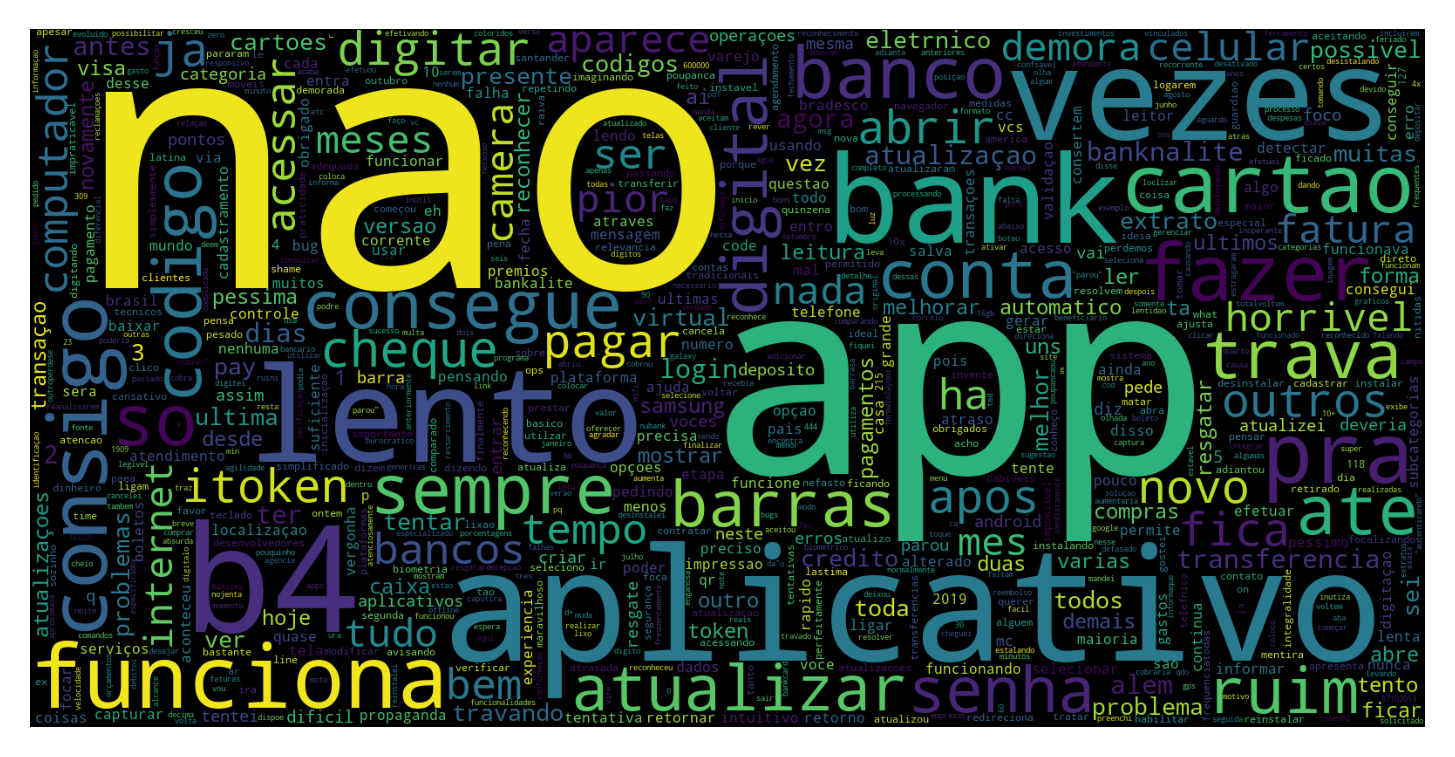

In [78]:
nuvem = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800).generate(" ".join(data_freq))

plt.figure(figsize=(6,4), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq.values))  # Passando as 50 primeiras pra um dicionario
plt.imshow(nuvem)
plt.axis('off')  # Para nao mostrar eixos
plt.show()

### Positivos

Faremos a nuvem de palavras também para os textos positivos e neutros, porém, para não alongar o arquivo, iremos simplificar e reduzir as células, já que os códigos são os mesmos da seção "Negativos".

In [79]:
lista_de_listas = df.loc[df['Sentiment']=='Positive']['Review Text'].values
palavras = [palavra for lista in lista_de_listas for palavra in lista]

freq_palavras = gera_freq_palavras(palavras)

lista_de_palavras = []
lista_de_frequencias = []

for palavra, frequencia in freq_palavras.items():
    lista_de_palavras.append(palavra)
    lista_de_frequencias.append(frequencia)

data_freq = pd.DataFrame({'palavra': lista_de_palavras, 'freq': lista_de_frequencias})
data_freq.sort_values('freq', ascending=False, inplace=True)

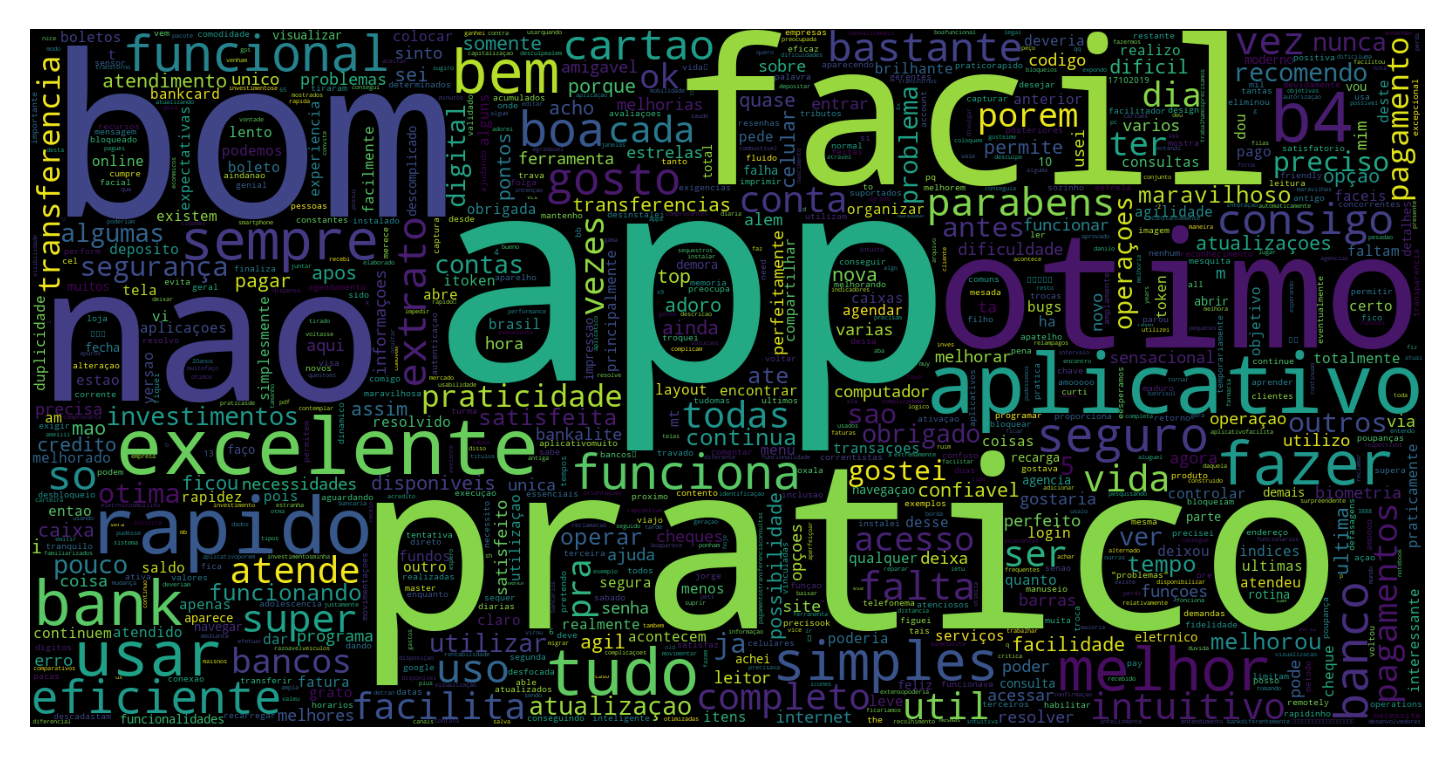

In [80]:
plt.figure(figsize=(6,4), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq.values))  # Passando as 50 primeiras pra um dicionario
plt.imshow(nuvem)
plt.axis('off')  # Para nao mostrar eixos
plt.show()

### Neutro

In [81]:
lista_de_listas = df.loc[df['Sentiment']=='Neutral']['Review Text'].values
palavras = [palavra for lista in lista_de_listas for palavra in lista]
freq_palavras = gera_freq_palavras(palavras)

lista_de_palavras = []
lista_de_frequencias = []

for palavra, frequencia in freq_palavras.items():
    lista_de_palavras.append(palavra)
    lista_de_frequencias.append(frequencia)

data_freq = pd.DataFrame({'palavra': lista_de_palavras, 'freq': lista_de_frequencias})
data_freq.sort_values('freq', ascending=False, inplace=True)

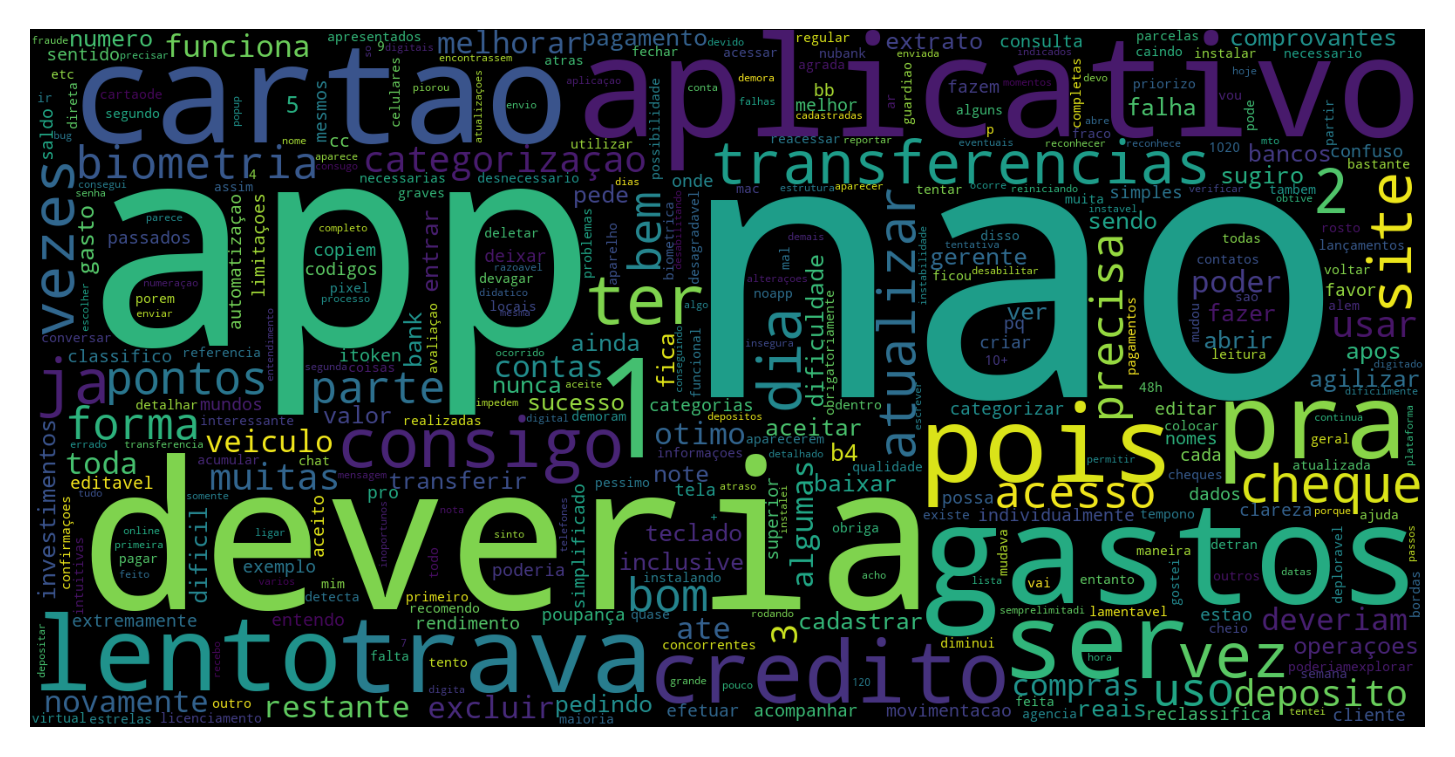

In [82]:
plt.figure(figsize=(6,4), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq.values))  # Passando as 50 primeiras pra um dicionario
plt.imshow(nuvem)
plt.axis('off')  # Para nao mostrar eixos
plt.show()

<a name="FRASE"></a>
<h2>4.3 Quantidade de palavras por frase</h2>

<a href='#TOPO'>Voltar ao índice</a>

Vamos verificar se a quantidade de palavras influenciam se o post será negativo, neutro ou positivo.

In [83]:
# Contando a quantidade de palavras por frase e passando para o df
df['Qtdd. Palavras'] = df['Review Text'].apply(len)

In [84]:
# Visualizando apenas os 5 primeiros do nosso df
df.head()

Review Text Sentiment  Qtdd. Palavras
2                                              [boa]  Positive               1
3  [nao, consigo, gerar, fatura, pdf, formatolayo...  Negative              14
5                                      [atende, bem]  Positive               2
7                                  [rapido, pratico]  Positive               2
8                                          [rapidez]  Positive               1

Observando os gráficos abaixo, podemos ver que a grande maioria das frases mais longas, são negativas, e outra pequena parte neutra. Para esse app as pessoas tendem a escrever mais quando a avaliação é negativa.  
Essa pode ser uma informação importante para o nosso modelo de machine learning.

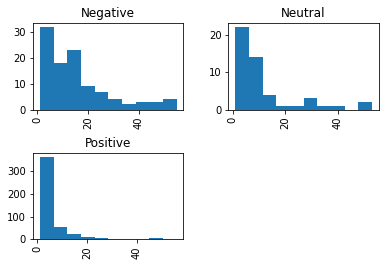

In [85]:
df.hist(column=['Qtdd. Palavras'], by='Sentiment')  # Separa por label
plt.show()

In [86]:
# Retornando a frase para não listas
df['Review Text'] = df['Review Text'].apply(lambda x: ' '.join(x))

<a name="REALIZANDO"></a>
<h2>4.4 Realizando Resample</h2>

<a href='#TOPO'>Voltar ao índice</a>

Como vemos nas células abaixo, nossos dados estão muito mais propícios para o sentimento positivo, para fazer a análise de sentimentos isso por ser ruim, pois temos muito mais informações do que é positivo, fazendo com que nosso modelo de machine learning possa considerar tudo posivo.  
Por esse motivo vamos utilizar a tecnica "Resample" que vai equilibrar os dados deixando as 3 categorias com a mesma quantidade.

In [87]:
# Quantidade de textos por categoria
df['Sentiment'].value_counts()

Positive    457
Negative    105
Neutral      49
Name: Sentiment, dtype: int64

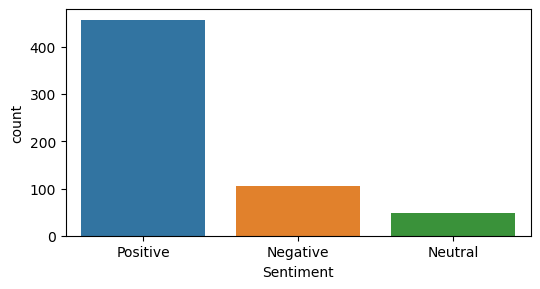

In [88]:
plt.figure(figsize=(6,3), dpi=100)
sns.countplot('Sentiment', data=df)
plt.show()

In [89]:
# Passando cada categoria para uma variável
df_pos = df.loc[df['Sentiment']=='Positive']
df_neg = df.loc[df['Sentiment']=='Negative']
df_neu = df.loc[df['Sentiment']=='Neutral']

Aqui poderíamos ter escolhido equilibrar os dados para as quantidades 457, 105 ou 49. De acordo com testes pré-realizados, o melhor número aqui seria o de 457, que acompanha a quantidade dos dados positivos.

In [90]:
# Função de equilíbrio dos dados
def equilibra_dados(train, pra_mais=True):
    df_pos = df.loc[df['Sentiment']=='Positive']
    df_neg = df.loc[df['Sentiment']=='Negative']
    df_neu = df.loc[df['Sentiment']=='Neutral']
    if pra_mais:
        menor_pro_maior = resample(df_neu, 
                           replace=True, 
                           n_samples=len(df_pos), 
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, df_pos])
        menor_pro_maior = resample(df_neg, 
                           replace=True, 
                           n_samples=len(df_pos), 
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, train_equilibrado])
    else:  # Faz o contrario, da maioria para a minoria
        menor_pro_maior = resample(df_pos, 
                           replace=True, 
                           n_samples=len(df_neg), 
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, df_neg])
        menor_pro_maior = resample(df_neu, 
                           replace=True, 
                           n_samples=len(df_neg), 
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, train_equilibrado])
    return train_equilibrado

In [91]:
# Equilibra os dados para 457
equilibra_dados(df, pra_mais=True)['Sentiment'].value_counts()

Neutral     457
Positive    457
Negative    457
Name: Sentiment, dtype: int64

In [92]:
# Passando os dados equilibrados para uma variável e escluindo a coluna qtdd. palavras
df_resample = equilibra_dados(df, pra_mais=True).drop('Qtdd. Palavras', axis=1)

<a name="ML"></a>
<h2>4.5 Machine Learning</h2>

<a href='#TOPO'>Voltar ao índice</a>

Finalmente iremos aplicar os modelos de machine learning.  
Aqui vamos escolher 3 modelos e realizar comparações entre eles através de validações.  
Quais modelos e por quê?
* Multinomial Naive bayes - É um modelo muito utilizado para análise de sentimentos, apresentando bons resultados na maioria das vezes.
* SVM (Support vector machine) - Como estamos utilizando somente 1 variável para a análise, vamos também utilizar esse modelo por ele ser linear e se dar bem com esse tipo de variável.
* SGD (Stochastic Gradient Descent) - Também geralmente aprensenta bons resultados, vamos utilizá-lo como uma referência entre os dois modelos acima.

In [93]:
# Passando cada uma das 2 colunas para uma variável
X = df_resample['Review Text']
y = df_resample['Sentiment']

In [94]:
# Realizando o train test split com 70% e 30% de divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [95]:
# Tamanhos das variáveis
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((959,), (959,), (412,), (412,))

Vamos também testar se adicionando uma tag de negação nas palavras 'não' melhoramos os nossos resultados

In [96]:
# Função que adiciona a tag _NEG para as palavras 'nao','not', 'no', 'n'
def marque_negacao(texto):
    negacoes = ['nao','not', 'no', 'n']
    negacao_detectada = False
    resultado = []
    palavras = texto.split()
    for p in palavras:
        p = p.lower()
        if negacao_detectada == True:
            p = p + '_NEG'
        if p in negacoes:
            negacao_detectada = True
        resultado.append(p)
    return (" ".join(resultado))

In [97]:
# pipeline do modelo MultinomialNB
pipeline_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', MultinomialNB())
])

In [98]:
# pipeline do modelo MultinomialNB com tag de negação
pipeline_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', MultinomialNB())
])

In [99]:
# pipeline do modelo SVM
pipeline_svm_simples = Pipeline([
  ('counts', CountVectorizer()),
  ('classifier', svm.SVC(kernel='linear'))
])

In [100]:
# pipeline do modelo SVM com tag de negação
pipeline_svm_negacoes = Pipeline([
  ('counts', CountVectorizer(tokenizer=lambda text: marque_negacao(text))),
  ('classifier', svm.SVC(kernel='linear'))
])

In [101]:
# pipeline do modelo SGD
sgd = Pipeline([
    ('countVector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('modelo', SGDClassifier())
])

<a name="VALIDACAO"></a>
<h2>4.6 Validação dos modelos de ML</h2>

<a href='#TOPO'>Voltar ao índice</a>

Como balanceamos os dados podemos utilizar a métrica de acurácia como referência.

In [102]:
# Função que aplica a métrica de acuracidade
def Metricas(modelo, texts, classes):
  resultados = cross_val_predict(modelo, texts, classes, cv=10)
  return 'Acurácia do modelo: {}'.format(metrics.accuracy_score(classes,resultados))

In [103]:
# MultinomialNB
Metricas(pipeline_simples,X_test,y_test)

'Acurácia do modelo: 0.8033980582524272'

In [104]:
# MultinomialNB com tag de negação
Metricas(pipeline_negacoes,X_test,y_test)

'Acurácia do modelo: 0.46601941747572817'

In [105]:
# SVM
Metricas(pipeline_svm_simples,X_test,y_test)

'Acurácia do modelo: 0.8762135922330098'

In [106]:
# SVM com tag de negação
Metricas(pipeline_svm_negacoes,X_test,y_test)

'Acurácia do modelo: 0.6868932038834952'

In [107]:
# SGD
Metricas(sgd,X_test,y_test)

'Acurácia do modelo: 0.8689320388349514'

Vamos escolher o modelo SVM sem tag de negação pois foi o que teve o melhor resultado.

In [108]:
# Gerando previsões para a matriz de confusão
resultados = cross_val_predict(pipeline_svm_simples, X_test, y_test, cv=10)

In [109]:
# Matrix de confusão
print(pd.crosstab(y_test, resultados, rownames=['Real'], colnames=['Predição'], margins=True))

Predição  Negative  Neutral  Positive  All
Real                                      
Negative       115       20        10  145
Neutral         10      121         3  134
Positive         6        2       125  133
All            131      143       138  412


<a name="PREVENDO"></a>
<h2>4.7 Prevendo sentimentos</h2>

<a href='#TOPO'>Voltar ao índice</a>

Agora vamos prever os sentimentos faltantes do nosso dataframe inicial.

In [110]:
# Somente os textos a serem previstos
prov = df.loc[df['Sentiment'].isnull()]['Review Text']

In [111]:
# Treino do modelo escolhido
pipeline_svm_simples.fit(X_train,y_train)

Pipeline(steps=[('counts', CountVectorizer()),
                ('classifier', SVC(kernel='linear'))])

In [112]:
# Passando as predições para uma variável
pred = pipeline_svm_simples.predict(prov)

# Transformando prov em um dataframe
df_vis = pd.DataFrame(prov)

# Adicionando os sentimentos faltantes
df_vis['Sentiment'] = pred

df_vis.head()  # Mostrando apenas os 5 primeiros

Review Text Sentiment
1438  bom app totalmente funcional continuem melhora...  Positive
1440                    sadisfatorio simples atualizado  Positive
1442         bom acompanhar movimentar aplicar finanças  Positive
1444                                     aplicativo top  Positive
1448                                           the best  Positive

In [113]:
# Quantidade por categoria, podemos ver que segue a superioridade do 'positive' como esperado
df_vis['Sentiment'].value_counts()

Positive    1154
Negative     223
Neutral      145
Name: Sentiment, dtype: int64

In [114]:
# Filtrando somente os sentimentos nao nulos
reviews_notnull = reviews.loc[reviews['Sentiment'].notnull()]

# Concatenando os sentimentos já conhecidos com os previstos
sentiment_full = pd.concat([reviews_notnull['Sentiment'],df_vis['Sentiment']], axis=0)

# Removendo a coluna sentiment do primeiro dataframe
reviews.drop('Sentiment',axis=1, inplace=True)

# Add a nova coluna 'Sentiment' com os dados já conhecidos e previstos
reviews = pd.concat([reviews,sentiment_full], axis=1)

reviews[['Review Text','Sentiment']][-25:]  # Mostrando os 25 últimos

Review Text Sentiment
5625           Não estou conseguindo atualizar este app  Negative
5626                           Atualização não acontece  Negative
5627  O aplicativo pede atualização mas não atualiza...  Negative
5629                                          nao falha  Negative
5633                      Teclado dda precisa melhorar.  Negative
5635                        Vocês estão de parabéns....  Positive
5636              Nada prático. Organização visual ruim  Negative
5637                                          Otimo app  Positive
5639                            Excelente app parabéns.  Positive
5642                              Fácil e funciona bem.  Positive
5644           Ótimo aplicativo. Faço tudo pelo celular  Positive
5645                                    Demorando muito  Positive
5646           Muito bom. Atende às minhas necessidades  Positive
5649                                              Otimi  Positive
5650  Muito complexo Cada dia pior Bco pra jovem Cad...  Negative
5653  O App não está lendo código de barras; diz est...  Negative
5654  Era mais fácil antes, piorou um pouco, mas com...  Positive
5656                           Excelente aplicativo!!!!  Positive
5660  Atende todas as necessidades de uma versão móv...  Positive
5663                                   Bom App completo  Positive
5668  fácil de usar, localizar as tarefas/ transaçõe...  Positive
5673                                     Sempre nota 10  Positive
5674  Baixei a última versão recentemente, ainda não...  Positive
5677                Gostei muito prático, descomplicado  Positive
5678                          Vive parando de funcionar  Positive

# Conclusão

Com a finalização do nosso projeto, vemos que o App do B4 Bank é um bom APP, mas tiveram alguns problemas com as últimas atualizações. Isso sem dúvida reflete na avaliação conforme mostrado ao longo do projeto, onde pode-se notar uma queda ao longo do tempo. Com a nossa nuvem de palavras, podemos compreender um pouco melhor quais são os principais pontos positivos e negativos do APP e o que deveria ser mudado. Notamos também que aos finais de semana são computadas poucas avaliações, o que faz sentido.  
Com análise de sentimentos conseguimos classificar o faltante na nossa base de dados, e conseguimos um bom percentual de acertos. A predição seguiu o conceito de que o percentual de sentimentos positivos é maior que os negativos, mas mostrou que isso vem diminuindo.  

Poderiamos melhorar alguns pontos no nosso projeto, como:  
Poderiamos ter melhorado ainda mais nosso modelo de ML com featuring engineering e passando outras variáveis como a avaliação de estrelas para o nosso modelo. Poderíamos também estudar melhores parâmetros para os nossos modelos de ML.  
Além da análise de sentimentos, também poderíamos aplicar conceitos de séries temporais para prever a retenção e conversão de clientes, utilizando por exemplo: Prophet, SARIMA Model e LSTM.

Nesse último gráfico podemos constatar a queda das avaliações positivas com o auxílo da média móvel. A média móvel foi inserida com a janela da média dos últimos 7 dias, fazendo com que a visualização do gráfico fique mais limpa sem os ruídos das oscilações.

In [115]:
ps = reviews['Sentiment'].loc[reviews['Sentiment']=='Positive'].groupby(reviews['Review Last Update Date and Time'].dt.date).count()
ng = reviews['Sentiment'].loc[reviews['Sentiment']=='Negative'].groupby(reviews['Review Last Update Date and Time'].dt.date).count()
nt = reviews['Sentiment'].loc[reviews['Sentiment']=='Neutral'].groupby(reviews['Review Last Update Date and Time'].dt.date).count()

In [116]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ps.index, y=ps.values,
                    mode='lines', marker_color='#000080',
                    name='Positivo', opacity=0.35))
fig.add_trace(go.Scatter(x=ps.index, y=ps.rolling(window=7).mean().values,
                    mode='lines', marker_color='#00BFFF',
                    name='Positivo - Média Móvel'))
fig.add_trace(go.Scatter(x=ng.index, y=ng.values,
                    mode='lines', marker_color='#8B0000',
                    name='Negativo', opacity=0.35))
fig.add_trace(go.Scatter(x=ng.index, y=ng.rolling(window=7).mean().values,
                    mode='lines', marker_color='#DC143C',
                    name='Negativo - Média Móvel'))
fig.add_trace(go.Scatter(x=nt.index, y=nt.values,
                    mode='lines', marker_color='#1C1C1C',
                    name='Neutro', opacity=0.35))
fig.add_trace(go.Scatter(x=nt.index, y=nt.rolling(window=7).mean().values,
                    mode='lines', marker_color='#000000',
                    name='Neutro - Média Móvel'))

fig.update_layout(title_text='Média móvel de 7 dias e Evolução diária dos Sentimentos',
                 yaxis={'title':'Quantidade'}, xaxis={'title':''})

fig.show()